In [1]:
import librosa 
import opensmile 
import pandas as pd 
import os 
from openpyxl import load_workbook
import numpy as np
from sklearn import svm
from tqdm import tqdm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC 
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [2]:
path = "sound/audio_input_3"
wb = load_workbook('data_all_feature.xlsx')
sheet = wb['工作表1']
name_table = sheet["B"]
flow_table = sheet["C"]

In [3]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)
x = []
y = [] 
name = [] 
count = 0
count_low = 0 
count_high = 0 
name_list = []
for  index , dirname in enumerate(os.listdir(path)):
    name_list.append(dirname)
train_index , test_index  = train_test_split(range(0,len(name_list)),random_state=99, train_size=0.8)
train_name = []
test_name = []
for index in train_index:
    train_name.append(name_list[index])
for index in test_index:
    test_name.append(name_list[index])
    
test_name

['3699595',
 '6392346',
 '6277241',
 '5262794',
 '3682716',
 'A563007',
 '9888821',
 '1158282',
 '9703744',
 '6720278',
 '2918920']

In [4]:
train_x = []
train_y = []
train_name_list = [] 
for dirname in train_name:
        d = os.path.join(path,dirname)
        for filename in os.listdir(d):
            f = os.path.join(d,filename)
            ## audio feature processing 
            audio,sr = librosa.load(f,sr=None)
            ## Extract only 0.5 second 
            audio = audio[0:int(sr*0.4)]
            
            #audio = librosa.effects.time_stretch(audio,rate=t_factor)
            #feature = smile.process_signal(
            #audio,
            #sr
            #)
            ft = librosa.feature.mfcc(y=audio, sr=sr)
            ft = ft.T
            #ft = feature.to_numpy(dtype="float64")
            size = ft.shape
            ft = ft.reshape(1,size[0]*size[1])

            train_name_list.append(dirname[0:7])
            # find the associated flow in excel table 
            flag = 0

            for index,num in enumerate(name_table):
                if num.value == dirname[0:7]:
                    flag = 1
                    flow = flow_table[index].value
                    if flow > 1200 :
                        train_y.append(1)
                        train_x.append(ft[0])
                        count_high += 1 
                    else: 
                        train_y.append(0)
                        train_x.append(ft[0])
                        count_low += 1
            if flag == 0 :
                print(dirname[0:7])
print(len(train_x))       
train_x = np.array(train_x)
train_y = np.array(train_y) 


302


In [5]:
test_x = []
test_y = []
test_dict_x = {} 
for dirname in test_name:
        d = os.path.join(path,dirname)
        test_tmp_x= []
        for filename in os.listdir(d):
            f = os.path.join(d,filename)
            ## audio feature processing 
            audio,sr = librosa.load(f,sr=None)
            ## Extract only 0.5 second 
            #t = len(audio)/sr 
            #t_factor = t/0.5
            audio = audio[0:int(sr*0.4)]
            #audio = librosa.effects.time_stretch(audio,rate=t_factor)
            #feature = smile.process_signal(
            #audio,
            #sr
            #)
            ft = librosa.feature.mfcc(y=audio, sr=sr)
            ft = ft.T
            #ft = feature.to_numpy(dtype="float64")
            size = ft.shape
            ft = ft.reshape(1,size[0]*size[1])

            
            # find the associated flow in excel table 
            flag = 0
            
            for index,num in enumerate(name_table):
                if num.value == dirname[0:7]:
                    flag = 1
                    flow = flow_table[index].value
                    if flow > 1200 :
                        test_y.append(1)
                        test_x.append(ft[0])
                        test_tmp_x.append(ft[0])
                        count_high += 1
                    else: 
                        test_y.append(0)
                        test_x.append(ft[0])
                        test_tmp_x.append(ft[0])
                        count_low += 1
            if flag == 0 :
                print(dirname[0:7])
        test_tmp_x.append(test_y[-1])
        test_dict_x[dirname] = test_tmp_x

print(len(test_x))         
test_x = np.array(test_x)
test_y = np.array(test_y) 


84


In [6]:
print(f"number of samples that flow>1200 : {count_high}")
      
print(f"number of samples that flow<1200 : {count_low}")

number of samples that flow>1200 : 201
number of samples that flow<1200 : 185


In [7]:
x = np.concatenate([train_x,test_x])
print(x.shape)
sc = StandardScaler()
sc.fit(x)
train_x = sc.transform(train_x)
test_x = sc.transform(test_x)

(386, 140)


In [8]:
# Training with different parameters using polynomial kernal 
acc = 0 
best_c = 0
best_d = 0 
progress = tqdm(total = 100)
for d  in range(10):
    for c in range(10):
        clf = SVC(kernel= 'poly',degree=d, random_state=777,C=c+1)
        scores = cross_val_score(clf,train_x,train_y,cv=5,scoring='accuracy')
        acc_tmp = scores.mean()
        if acc_tmp > acc :
            best_c = c 
            best_d = d 
            acc = acc_tmp
        progress.update(1)
progress.close()
print(acc)
print(best_c)
print(best_d)
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.05it/s]

0.6655737704918032
5
3


In [9]:
clf = SVC(kernel= 'poly',degree=best_d, random_state=777,C=best_c+1)
clf.fit(train_x,train_y)
clf.score(test_x,test_y)

0.5357142857142857

In [10]:
### check result 
print("Result of Audio 3" )
count=0
incorrect_all = 0 
key_list = []
acc_list = []
correct_list = []
incorrect_list = []
for key in test_dict_x:
    label = test_dict_x[key][-1]
    feature = test_dict_x[key][0:-1]
    correct = 0 
    incorrect = 0 
    for audio in feature :
        count+=1
        audio = audio.reshape(1, -1)
        audio=sc.transform(audio)
        answer = clf.predict(audio)
        #print(answer)
        if answer == label :
            correct +=1 
        else :
            incorrect +=1 
            incorrect_all+=1
    acc = correct / (correct + incorrect)
    key_list.append(key)
    acc_list.append(acc)
    correct_list.append(correct)
    incorrect_list.append(incorrect)
for acc,key,correct,incorrect in sorted(zip(acc_list,key_list,correct_list,incorrect_list)):
    print(f"{key} : accuracy = {acc:.3f} , correct / all = {correct} / {correct+incorrect}" )


Result of Audio 3
9888821 : accuracy = 0.000 , correct / all = 0 / 8
A563007 : accuracy = 0.000 , correct / all = 0 / 8
3682716 : accuracy = 0.167 , correct / all = 1 / 6
6392346 : accuracy = 0.167 , correct / all = 1 / 6
2918920 : accuracy = 0.625 , correct / all = 5 / 8
6277241 : accuracy = 0.625 , correct / all = 5 / 8
3699595 : accuracy = 0.667 , correct / all = 6 / 9
6720278 : accuracy = 0.857 , correct / all = 6 / 7
1158282 : accuracy = 0.875 , correct / all = 7 / 8
5262794 : accuracy = 0.875 , correct / all = 7 / 8
9703744 : accuracy = 0.875 , correct / all = 7 / 8


Confusion matrix, without normalization
[[12 19]
 [20 33]]
Normalized confusion matrix
[[12 19]
 [20 33]]


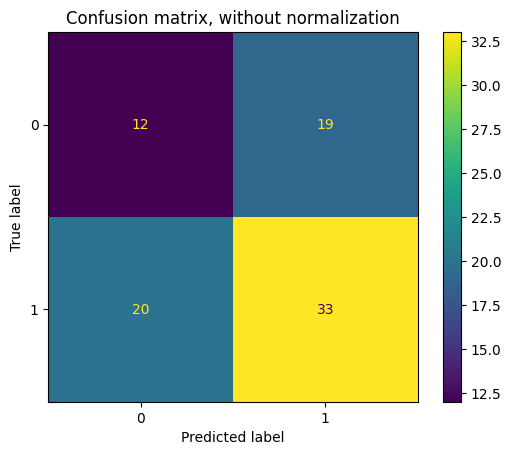

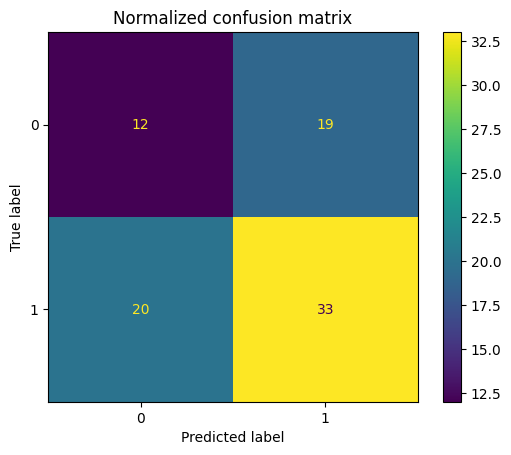

In [11]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(clf,test_x,test_y)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [12]:
import os 
directory = "sound/audio_input_2"
os.listdir(directory)


['6023662',
 '7598608',
 '1406897',
 'B987967',
 '9423853',
 '2898255',
 '3130262',
 '9985055',
 'A526770',
 '1090214',
 '1932905',
 '1980209',
 '9798781',
 '9703744',
 '6106202',
 '3283431',
 '1251521',
 'B547181',
 '7850111',
 '6720278',
 '3523570',
 '3699595',
 '5262794',
 '4910370',
 '6277241',
 '2573891',
 '0934441',
 '8247125',
 'B326929',
 '1121538',
 '5773646',
 '7998339',
 '2918920',
 '1152355',
 '6392346',
 '3262855',
 '8106153',
 '8302630',
 '1123429',
 '9073913',
 'A563007',
 '3682716',
 '2734792',
 'A889463',
 '5617204',
 '0775431',
 '1158282',
 '3219094',
 '2433946',
 'B243252',
 '8266733',
 '3054498',
 '1974434',
 '1763716']